In [1]:
from google.colab import drive
import os, pathlib
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

REPO_URL   = "https://github.com/Svanzi/Tennis-Shot-Recognition.git"
BASE       = "/content/drive/MyDrive/University/Deep"
SPARSE_DIR = "Tennis-Shot-Recognition"   # repo "leggera" solo per i dati
TARGET     = f"{BASE}/{SPARSE_DIR}"

os.makedirs(BASE, exist_ok=True)

# Clona in modalità sparse solo la prima volta
if not os.path.exists(TARGET):
    %cd {BASE}
    !git clone --filter=blob:none --sparse {REPO_URL} {SPARSE_DIR}
    %cd {SPARSE_DIR}
    !git sparse-checkout set DataSet
else:
    %cd {TARGET}
    !git pull

# Path da usare nel notebook
from pathlib import Path
DATA_DIR = Path(TARGET) / "DataSet"
print("DATA_DIR =", DATA_DIR)

Mounted at /content/drive
/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 498 bytes | 27.00 KiB/s, done.
Resolving deltas: 100% (2/2), completed with 1 local object.
From https://github.com/Svanzi/Tennis-Shot-Recognition
   e834648..24a8060  main       -> origin/main
Updating e834648..24a8060
Fast-forward
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1/1), 23.70 KiB | 836.00 KiB/s, done.
 Shot_Classification.ipynb | 652 +++++++++++++++++++++++++++++++++++++++++++---
 1 file changed, 623 insertions(+), 29 deletions(-)
DATA_DIR = /content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet


In [45]:
DATA_DIR = Path("/content/drive/MyDrive/University/Deep/Tennis-Shot-Recognition/DataSet")
players = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])

X=[]
Y=[]
x_test=[]
y_test=[]

for player in tqdm(players, desc="Players", leave=False):
    print(f"\n**** Parsing the shots of {player.name} ****\n")
    for shot_csv in sorted(player.glob("*.csv")):
        print(shot_csv.name)
        data = pd.read_csv(shot_csv)

        data_train = data[:int(0.8*len(data))]
        data_test = data[int(0.8*len(data)):]

        features_train = list(data_train.loc[:, data.columns != 'shot'].to_numpy())
        features_test = list(data_test.loc[:, data.columns != 'shot'].to_numpy())

        X.extend(features_train)
        Y.extend(data_train["shot"].to_numpy().flatten())

        x_test.extend(features_test)
        y_test.extend(data_test["shot"].to_numpy().flatten())

X = np.stack(X, axis=0)
X = np.array(X)
Y = np.array(Y)
y_test = np.array(y_test)

print("\n\n")
print(f"Loaded {len(Y)} shots for training")
print(f"Loaded {len(y_test)} shots for test")

Players:   0%|          | 0/2 [00:00<?, ?it/s]


**** Parsing the shots of Alcaraz ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
forehand_027.csv
forehand_028.csv
forehand_029.csv
forehand_030.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.csv
neutral_017.csv
neutral_018.csv
neutral_019.csv
neutral_020.csv
neutral_02

Players:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s]

neutral_030.csv
neutral_031.csv
neutral_032.csv
neutral_033.csv
neutral_034.csv
neutral_035.csv
neutral_036.csv

**** Parsing the shots of Sinner ****

backhand_001.csv
backhand_002.csv
backhand_003.csv
backhand_004.csv
backhand_005.csv
backhand_006.csv
backhand_007.csv
backhand_008.csv
forehand_001.csv
forehand_002.csv
forehand_003.csv
forehand_004.csv
forehand_005.csv
forehand_006.csv
forehand_007.csv
forehand_008.csv
forehand_009.csv
forehand_010.csv
forehand_011.csv
forehand_012.csv
forehand_013.csv
forehand_014.csv
forehand_015.csv
forehand_016.csv
forehand_017.csv
forehand_018.csv
forehand_019.csv
forehand_020.csv
forehand_021.csv
forehand_022.csv
forehand_023.csv
forehand_024.csv
forehand_025.csv
forehand_026.csv
neutral_001.csv
neutral_002.csv
neutral_003.csv
neutral_004.csv
neutral_005.csv
neutral_006.csv
neutral_007.csv
neutral_008.csv
neutral_009.csv
neutral_010.csv
neutral_011.csv
neutral_012.csv
neutral_013.csv
neutral_014.csv
neutral_015.csv
neutral_016.csv
neutral_017.cs

neutral_027.csv
neutral_028.csv
neutral_029.csv
neutral_030.csv
neutral_031.csv
neutral_032.csv
neutral_033.csv



Loaded 3360 shots for training
Loaded 980 shots for test


In [36]:
print(X)

[[0.47537094 0.42198735 0.480145   ... 0.43361482 0.7864063  0.4828802 ]
 [0.4759235  0.4219989  0.47949362 ... 0.43354845 0.7880765  0.47143674]
 [0.47548828 0.4219664  0.47920176 ... 0.43335754 0.79009086 0.45664233]
 ...
 [0.45424196 0.34041843 0.4637692  ... 0.31002524 0.77155685 0.3890084 ]
 [0.45499817 0.34166566 0.46419644 ... 0.31127426 0.7705901  0.39130765]
 [0.4561     0.34284395 0.4648346  ... 0.3112963  0.7706611  0.39440447]]


In [46]:
# Robust counts (and sorted)
shots, counts = np.unique(Y, return_counts=True)
order = np.argsort(counts)[::-1]
shots, counts = shots[order], counts[order]

def pie_plot(shots, counts):

  fig, ax = plt.subplots()

  # Pie with percentages
  wedges, texts, autotexts = ax.pie(
      counts,
      autopct='%1.1f%%',
      startangle=90
  )

  ax.axis('equal')
  ax.set_title('Shots dataset')

  # Legend on the side with "label — count"
  legend_labels = [f"{label} — {cnt}" for label, cnt in zip(shots, counts)]
  ax.legend(
      wedges, legend_labels,
      title="Shots (counts)",
      loc="center left",
      bbox_to_anchor=(1.02, 0.5),
      frameon=False
  )

  plt.tight_layout()
  plt.show()

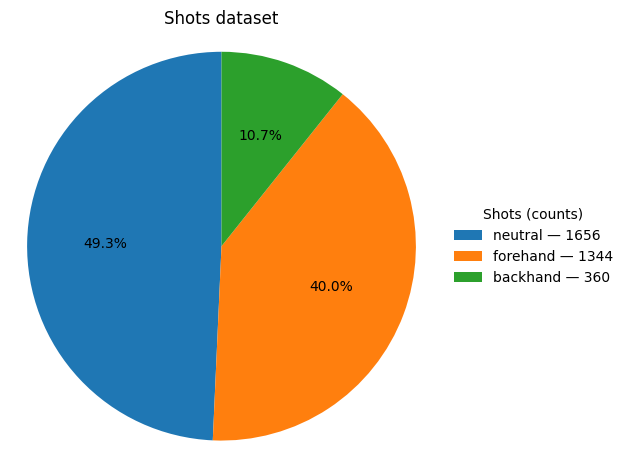

In [47]:
pie_plot(shots, counts)

In [48]:
# Take backhand occurences and cap all other classes to this value

target_occurences_per_class = np.count_nonzero(Y == "backhand")
subset_indices = []
for shot in shots:
    indices = np.argwhere(Y == shot)
    size_subset = min(target_occurences_per_class, len(indices))
    assert(len(indices)>= size_subset)
    subset_indices.extend((np.random.choice(indices[:, 0], size=size_subset, replace = False)))

subset_indices = np.sort(subset_indices)

equalized_Y = Y[subset_indices]
equalized_X = X[subset_indices]

equalized_occurences = [np.count_nonzero(equalized_Y == shot) for shot in shots]

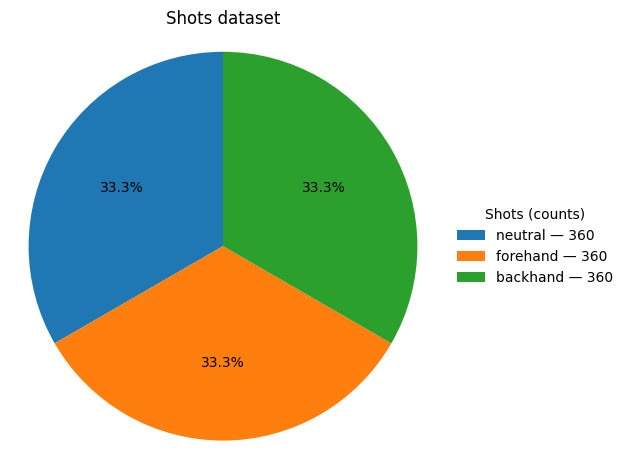

In [49]:
pie_plot(shots, equalized_occurences)